<h1>Why do users churn? A userbase dataset analysis</h1>
<h3>Notebook for the Capstone Project of the Google Advanced Data Analytics Certificate</h3>
<i>Author: Joshua Stevenson-Hoare</i>

[Original data source and more information at Coursera](https://www.coursera.org/learn/google-advanced-data-analytics-capstone)

In [2]:
# import general packages
import numpy as np
import pandas as pd
import scipy as sc
import pickle

In [3]:
# import visualisation packages
import seaborn as sns
import matplotlib.pyplot as plt

In [409]:
# import data science packages
from sklearn import metrics, tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split

In [4]:
# import dataset
df = pd.read_csv("HR_capstone_dataset.csv")

<h2>Dataset Overview</h2>
The dataset used here is a set of <b>14,999 employees</b> from the fictional Salifort Motors company.  The dataset contains information from self-assessments & manager assessments of employees, information on their tenure in the company, and HR information such as department and salary grade.

The variables in the data are summarised in the table below.

| Variable | Datatype | Contents |
| :-- | :-- | :-- |
| left | logical | Has the employee resigned? |
| satisfaction_level | float | Self-assessed satisfaction score, between 0 and 1 |
| last_evaluation | float | Line-manager assessed evaluation score for employee, between 0 and 1 |
| number_project | integer | Current number of projects assigned to |
| average_monthly_hours | integer | Rounded number of hours worked per month |
| time_spend_company | integer | Number of years the employee has been with the company |
| work_accident | logical | Has the employee ever experienced a workplace accident? |
| promotion_last_5years | logical | Has the employee had a promotion in the last 5 years of their employment? |
| department | string | Department in which the employee is currently working |
| salary | category | Employee's current salary, graded as low / medium / high |

<h3>Data Preparation</h3>
Prior to the data analysis, some cleaning must be performed on the dataset. 

In [5]:
# Rename columns to make spelling and capitalisation consistent.
rename_columns = {"average_montly_hours" : "average_monthly_hours",
                  "Work_accident" : "work_accident",
                  "Department" : "department"}
df = df.rename(columns=rename_columns)

In [6]:
# Evaluate if there are any missing values in the dataset
df.isna().sum()

satisfaction_level       0
last_evaluation          0
number_project           0
average_monthly_hours    0
time_spend_company       0
work_accident            0
left                     0
promotion_last_5years    0
department               0
salary                   0
dtype: int64

In [7]:
# Move the outcome variable, left, to the start of the dataset for easier user parsing
col = df.pop('left')
df.insert(0, col.name, col)

In [33]:
# for more understandable plots
df["resigned"] = df["left"].astype("bool")

In [32]:
# view the now cleaned dataset
df.head(5)

,left,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,work_accident,promotion_last_5years,department,salary,resigned
0,1,0.38,0.53,2,157,3,0,0,sales,low,True
1,1,0.80,0.86,5,262,6,0,0,sales,medium,True
2,1,0.11,0.88,7,272,4,0,0,sales,medium,True
3,1,0.72,0.87,5,223,5,0,0,sales,low,True
4,1,0.37,0.52,2,159,3,0,0,sales,low,True


<h3>Analysis Plan</h3>
A <b>Random Forest</b> will be used to create the prediction model.  This method is advantageous for the following reasons:

1. There are multiple datatypes of interest, including categorical, string, integer, and float values.  Random Forests are able to incorporate multiple datatypes without additional data transformation.
2. The output of a Random Forest model is a flowchart, which is human-readable.  This improves the explicability compared to a "black-box" model.
3. Random Forests automatically reduce the number of variables required.  Therefore, data preparation does not need to perform, e.g., LASSO regression, to identify the most important predictors.
4. Optimisation of Random Forest hyperparameters can be performed using parallel computing nodes.  This makes the model generation process faster and more efficient.

<h2>Data Exploration</h2>

<h3>Number of Resigned Employees</h3>
How many employees have churned in Salifort Motors within this dataset?

In [9]:
left_remained = df["left"].value_counts()
left_percentage = left_remained[1] / (left_remained[0] + left_remained[1])
print("Number of employees who resigned: " + str(left_remained[1]) + " of " + str(df.shape[0]) +
      "\nPercentage of dataset: " + str(round(left_percentage*100,1)) + "%")

Number of employees who resigned: 3571 of 14999
Percentage of dataset: 23.8%


<h3>Relationship with Other Variables</h3>

In [10]:
# split into those who left and those who did not
resigned = df[df["left"]==1]
stayed = df[df["left"] == 0]

<b>Time spent with the company</b>

In [27]:
# cross tabulate number of resignations per number of years spend at the company
time_spent_left = pd.crosstab(df['left'], df['time_spend_company']).stack().reset_index(name="num_employees")

# get the total number of employees per year spent at the company
time_spent = df["time_spend_company"].value_counts().reset_index().sort_values(by="time_spend_company")

# get the percentage value of resignations out of all employees with that tenure
time_spent_left["num_resigned_percentage"] = time_spent_left["num_employees"]/ \
    list(pd.concat([time_spent["count"],time_spent["count"]],axis=0)) * 100

# get the percentage value of resignations out of all resignations
time_spent_resigned = time_spent_left[time_spent_left["left"]==1].reset_index(drop=True)
newrow = pd.DataFrame({"left":1,"time_spend_company":1,"num_employees":0,"num_resigned_percentage":0},index=[0])
time_spent_resigned = pd.concat([newrow,time_spent_resigned])

# resignations per year as a percentage of all resignations
time_spent_resigned["percent_of_resignations"] = time_spent_resigned["num_employees"] / time_spent_resigned["num_employees"].sum() * 100

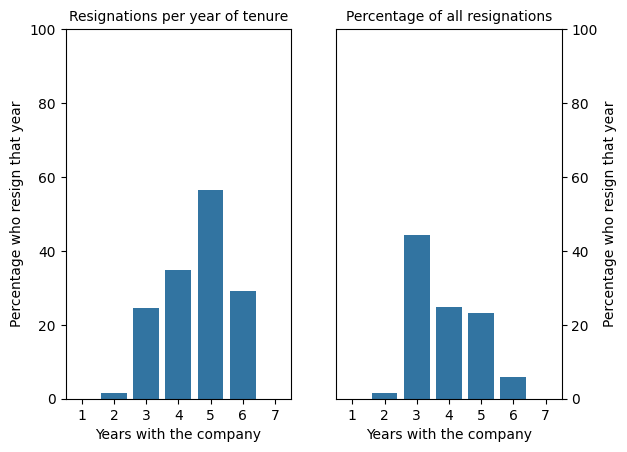

In [28]:
fig, (resigns_per_year, resigns_percent) = plt.subplots(ncols=2, sharey=False)

sns.barplot(time_spent_resigned, x="time_spend_company", y="num_resigned_percentage", ax=resigns_per_year)
resigns_per_year.set_title("Resignations per year of tenure",fontsize=10)
resigns_per_year.set_xlabel("Years with the company"); resigns_per_year.set_xlim((-0.5,6.5))
resigns_per_year.set_ylabel("Percentage who resign that year"); resigns_per_year.set_ylim((0,100))


sns.barplot(time_spent_resigned, x="time_spend_company", y="percent_of_resignations", ax=resigns_percent)
resigns_percent.set_title("Percentage of all resignations", fontsize=10)
resigns_percent.set_xlabel("Years with the company"); resigns_percent.set_xlim((-0.5,6.5))
resigns_percent.set_ylabel("Percentage who resign that year"); resigns_percent.set_ylim((0,100))
resigns_percent.yaxis.tick_right(); resigns_percent.yaxis.set_label_position("right")

plt.show()

Interestingly, it appears that most resignations happen in the 5th year of an employee's tenure at the company.  However, of the employees that do leave, the most common year is the third.  Of those individuals who stay for 7 years or greater, there were no resignations recorded.  There were also no resignations recorded in the first year, although this may be due to data missingness.

<b>Line Manager Evaluation</b>

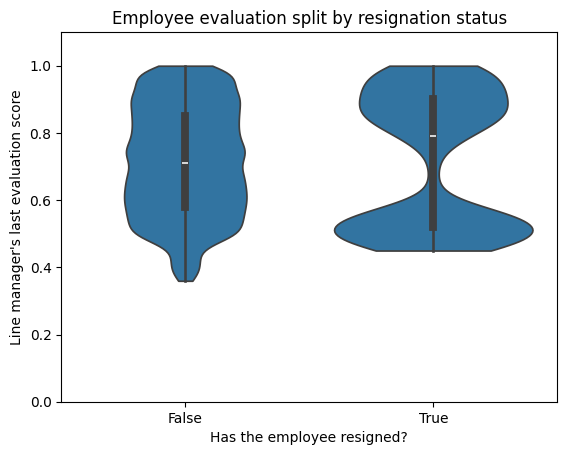

In [35]:
sns.violinplot(df, x="resigned", y="last_evaluation", cut=0)
plt.ylim((0,1.1))
plt.xlabel("Has the employee resigned?"); plt.ylabel("Line manager's last evaluation score")
plt.title("Employee evaluation split by resignation status")
plt.show()

Employees who have not resigned have a uniform distribution of line manager evaluations.  Employees who have resigned, however, have a very bimodal distribution.  One explanation for this might be that there are two reasons why people resign, and these differ between high performing and low performing employees.  

<i>Highly-rated employees</i> might be seeking promotions or advancing their career in another company.  

<i>Low-rated employees </i> might be quitting due to their poor performance or feedback.

<b>Self-Satisfaction Level</b>

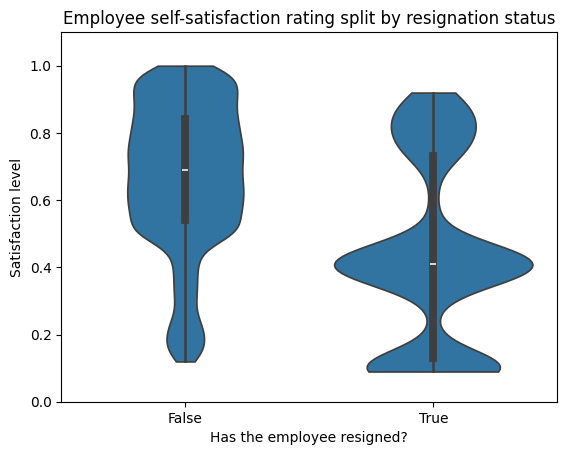

In [36]:
sns.violinplot(df, x="resigned", y="satisfaction_level", cut=0)
plt.ylim((0,1.1))
plt.xlabel("Has the employee resigned?"); plt.ylabel("Satisfaction level")
plt.title("Employee self-satisfaction rating split by resignation status")
plt.show()

Employees who resign appear to overall rate their satisfaction as lower.  However this is not uniform across all resigning employees.  In fact we see a trimodal distribution.  Some resigners are extremely unsatisfied, most are middling satisfaction, and some are very high satisfaction.

It would be interesting to see how this relates to manager performance ratings, to see if there is a connection we can investigate further.

<b>Evaluation vs Satisfaction</b>

In [214]:
# bin the data for easier plot readability
sat_eval = df[["satisfaction_level", "last_evaluation", "resigned"]].copy()
sat_eval["sat_binned"] = np.digitize(sat_eval["satisfaction_level"], \
                                     bins = np.arange(0.0,1.0,step=0.05))/10
sat_eval["eval_binned"] = np.digitize(sat_eval["last_evaluation"], \
                                     bins = np.arange(0.0,1.0,step=0.05))/10

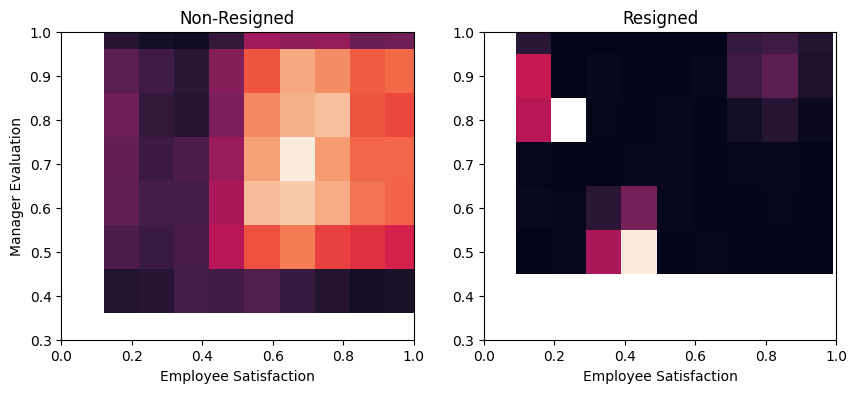

In [216]:
fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(10,4))

    #non resigned
sns.histplot(sat_eval[sat_eval["resigned"]==False], ax=ax1,  x="satisfaction_level", y="last_evaluation", binwidth=0.1, cmap="rocket")
ax1.set_title("Non-Resigned")
ax1.set_xlabel("Employee Satisfaction"); ax1.set_ylabel("Manager Evaluation")
ax1.set_xlim((0,1)); ax1.set_ylim((0.3,1))

sns.histplot(sat_eval[sat_eval["resigned"]==True], ax=ax2, x="satisfaction_level", y="last_evaluation", binwidth=0.1, cmap="rocket")
ax2.set_title("Resigned")
ax2.set_xlabel("Employee Satisfaction"); ax2.set_ylabel("")
ax2.set_xlim((0,1)); ax2.set_ylim((0.3,1))

plt.show()

Employees who did not resign appear to form a cloud, where there is no clear relationship between employee satisfaction and manager evaluation.

Employees who did resign show three distinct groups on these two variables.
1. High evaluation, low satisfaction
2. Medium evaluation, medium satisfaction 
3. High evaluation, high satisfaction

<b>Department</b>

In [257]:
resigned_per_department = pd.DataFrame(df["department"].value_counts())
resigned_per_department["percent_turnover"] = resigned["department"].value_counts() / resigned_per_department["count"] *100
resigned_per_department["of_resignations"] = resigned["department"].value_counts() / resigned.shape[0]
resigned_per_department.reset_index()

,department,count,percent_turnover,of_resignations
0,sales,4140,24.492754,0.283954
1,technical,2720,25.625000,0.195183
2,support,2229,24.899058,0.155419
3,IT,1227,22.249389,0.076449
4,product_mng,902,21.951220,0.055447
5,marketing,858,23.659674,0.056847
6,RandD,787,15.374841,0.033884
7,accounting,767,26.597132,0.057127
8,hr,739,29.093369,0.060207
9,management,630,14.444444,0.025483


C:\Users\jstev\AppData\Local\Temp\ipykernel_18064\2125022320.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(),rotation=45, ha='right')
C:\Users\jstev\AppData\Local\Temp\ipykernel_18064\2125022320.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(),rotation=45, ha='right')


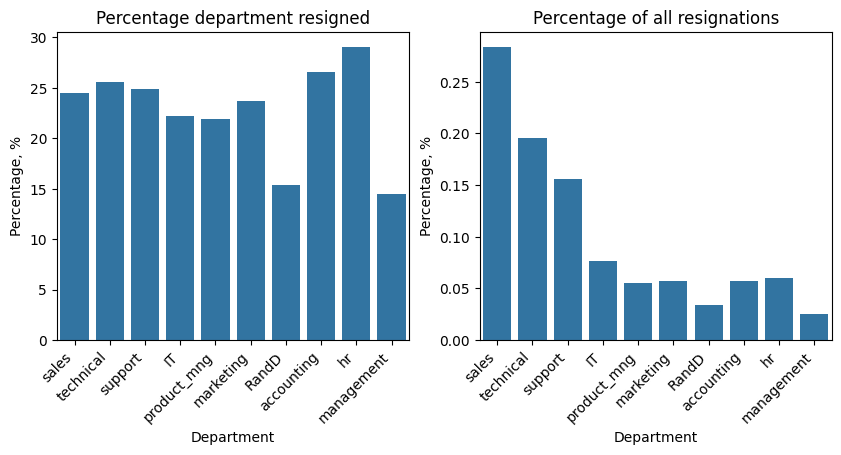

In [269]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,4))

# percentage turnover per department
sns.barplot(resigned_per_department, ax=ax1, x="department", y="percent_turnover")
ax1.set_title("Percentage department resigned")
ax1.set_xlabel("Department"); ax1.set_ylabel("Percentage, %")
ax1.set_xticklabels(ax1.get_xticklabels(),rotation=45, ha='right')

# turnover as a percentage of all resignations
sns.barplot(resigned_per_department, ax=ax2, x="department", y="of_resignations")
ax2.set_title("Percentage of all resignations")
ax2.set_xlabel("Department"); ax2.set_ylabel("Percentage, %")
ax2.set_xticklabels(ax2.get_xticklabels(),rotation=45, ha='right')

plt.show()

The departments with the highest % turnover are ```Accounting``` and ```HR```.  Lowest % turnover is seen in the ```R&D``` and ```Management``` groups.

However, ```Sales``` makes up the greatest proportion of employee resignations.  By contrast, ```Accounting``` and ```HR``` have comparatively very small proportions of the overall resignations.  This reflects their smaller total employee size.

<b>Department vs Satisfaction</b>
Is there some reason why different departments have different rates of turnover?  Perhaps employee satisfaction differs between these groups, which we know is related to resignation status.

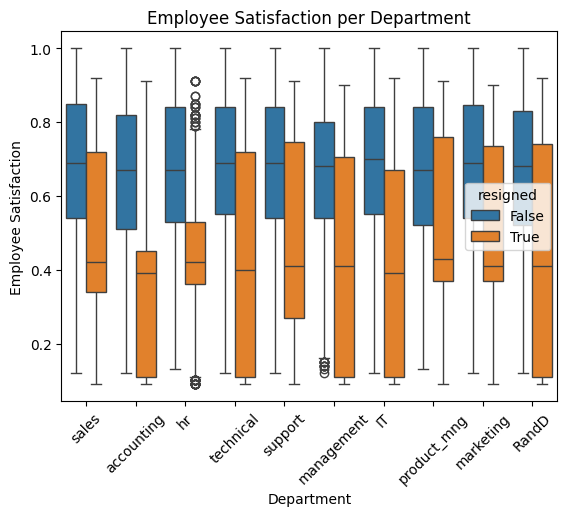

In [276]:
sns.boxplot(df, x="department", y="satisfaction_level", hue="resigned")
plt.title("Employee Satisfaction per Department")
plt.xlabel("Department"); plt.ylabel("Employee Satisfaction")
plt.xticks(rotation=45)
plt.show()

It appears that some departments show more differences in satisfaction than others.  For example in ```Accounting``` employees who resign are almost all much less satisfied than those who stay.  Whereas in ```Product Management``` and ```Marketing``` this difference is not as strong.  

In all departments, employees who do not resign are similar in their levels of satisfaction.

<b>Other Variables</b>
As most other variables are simple categorical questions, it is faster to view these in a larger group.

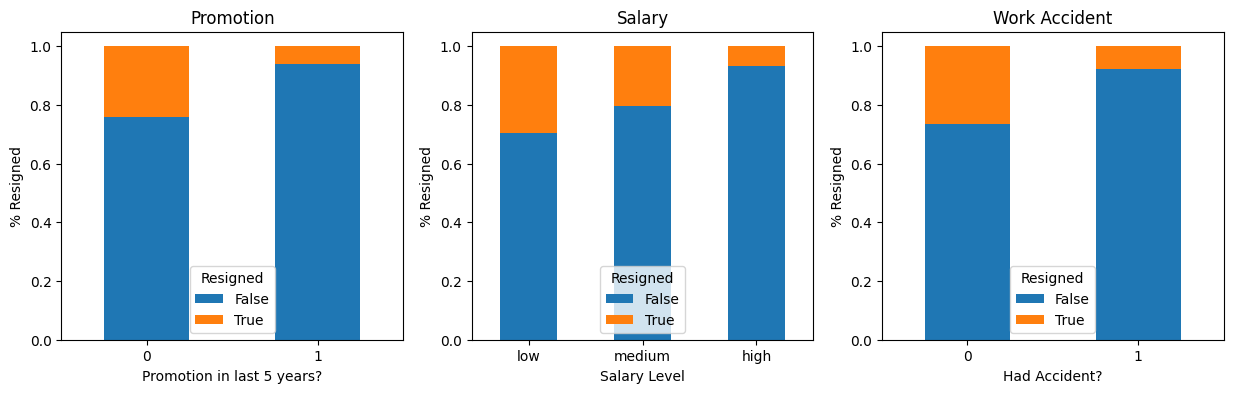

In [327]:
other_vars = df[["resigned", "work_accident", "promotion_last_5years", "salary"]]
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(15,4))
# been promoted?
promoted = pd.crosstab(other_vars["promotion_last_5years"], other_vars["resigned"], normalize="index")
promoted.plot.bar(rot=0, ax=ax1, stacked=True)
ax1.set_title("Promotion"); ax1.set_xlabel("Promotion in last 5 years?"), ax1.set_ylabel("% Resigned")
ax1.legend(title="Resigned",loc="lower center")

# salary level?
salary = pd.crosstab(other_vars["salary"], other_vars["resigned"], normalize="index").reindex(["low","medium","high"],axis="index")
salary.plot.bar(rot=0, ax=ax2, stacked=True)
ax2.set_title("Salary"); ax2.set_xlabel("Salary Level"), ax2.set_ylabel("% Resigned")
ax2.legend(title="Resigned",loc="lower center")

# accident at work?
accident = pd.crosstab(other_vars["work_accident"], other_vars["resigned"], normalize="index")
accident.plot.bar(rot=0, ax=ax3, stacked=True)
ax3.set_title("Work Accident"); ax3.set_xlabel("Had Accident?"), ax3.set_ylabel("% Resigned")
ax3.legend(title="Resigned",loc="lower center")

plt.show()

For ```Promotion```, employees who had not had a promotion in the last five years were more likely to resign.

For ```Salary```, higher salaries were associated with lower rates of resignation.

However, for ```Work Accident``` curiously employees were less likely to resign if they had had an accident at work.  However, given that work accidents may be related to department - this should be examined on a per-department basis.


<b>Accidents per Department</b>

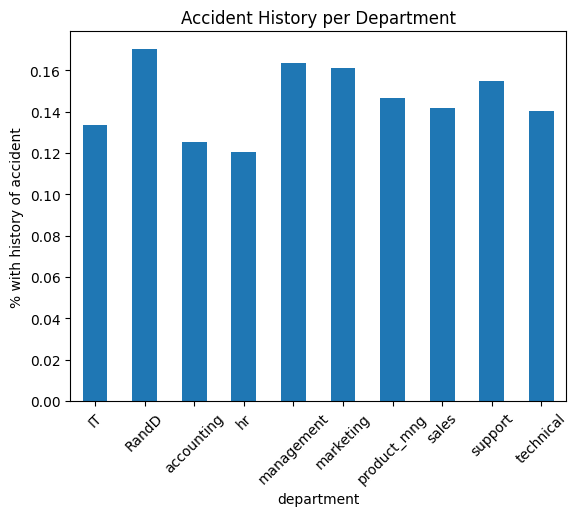

In [406]:
accident_per_department = pd.DataFrame(pd.crosstab(df["work_accident"],df["department"],normalize="columns"))
accident_per_department.iloc[1].plot.bar(rot=1,stacked=False)
plt.xticks(rotation=45); plt.ylabel("% with history of accident")
plt.title("Accident History per Department")
plt.show()

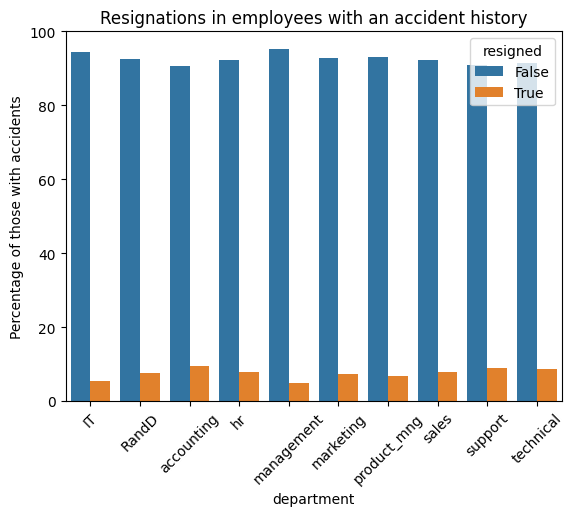

In [405]:
acc_dep_res = df.groupby(['work_accident','department']).resigned.value_counts(normalize=True).mul(100).reset_index()
sns.barplot(acc_dep_res[acc_dep_res["work_accident"]==1], x="department",y="proportion",hue="resigned")
plt.xticks(rotation=45); plt.ylabel("Percentage of those with accidents"); plt.ylim((0,100))
plt.title("Resignations in employees with an accident history")
plt.show()

While there appears to be a difference in the rate of accidents between different departments, when only those employees who have had an accident are considered, there does not appear to be a difference between departments.  It appears that having a workplace accident decreases your likelihood of leaving, and this is unrelated to department.

This may be a relationship mediated by another factor, such as duration of employee tenure. 

<b>Number of Projects</b>

In [442]:
projects = pd.crosstab(df["number_project"], df["resigned"])
projects

resigned,False,True
number_project,,
2,821,1567
3,3983,72
4,3956,409
5,2149,612
6,519,655
7,0,256


There is a clear class imbalance depending on the number of projects.  This should be included in the model but with care.

<h3>Exploration Summary</h3>
From this exploration, the factors that are most related to whether an employee resigns are: 

*  Number of years with the company
*  Employee satisfaction
*  Line manager evaluation
*  Department
*  Number of projects

<h2>Model Building</h2>
The model that has been chosen is a Random Forest.  As part of this process, hyperparameter optimisation will be performed with a cross-validated grid-search.

Based on the data exploration, the ```department``` & ```work_accident``` variables will be dropped from the dataset.

In [539]:
# make training, validation, and test datasets
df_model = df.drop(labels=["department","work_accident","resigned"], axis=1)

#transform some variables
df_model = pd.get_dummies(df_model, drop_first=True)
df_model.head()

,left,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,promotion_last_5years,salary_low,salary_medium
0,1,0.38,0.53,2,157,3,0,True,False
1,1,0.80,0.86,5,262,6,0,False,True
2,1,0.11,0.88,7,272,4,0,False,True
3,1,0.72,0.87,5,223,5,0,True,False
4,1,0.37,0.52,2,159,3,0,True,False


In [486]:
# do the splits
x_predictors = df_model.drop(labels=["left"],axis=1)
y_outcome = df["left"]

# we do not need a validation dataset as the grid-search will use cross-validation
x_train, x_test, y_train, y_test = train_test_split(x_predictors, y_outcome, test_size=0.2, stratify=y_outcome, random_state=500)

In [487]:
# make the basic model
rf = RandomForestClassifier(random_state=100)

# generate the hyperparameters
params = {"max_depth" : [2,3,4,5], # tree depth
          "min_samples_split" : [0.05, 0.1, 0.2], # minimum samples needed for a split
          "min_samples_leaf" : [0.02, 0.05, 0.08], # minimum samples needed for a leaf
          "max_features" : ["sqrt", "log2", None]
         }

As we want to identify people who might resign as best as possible, we are most interested in <b>Recall</b>.  This is because it is less of a problem if we intervene on someone who is happy, and it is a greater cost to the company if we miss someone whose position we need to refill, train, etc.

<h3>Grid Search for Hyper-Parameters</h3>

In [488]:
out = GridSearchCV(estimator=rf, cv=5, param_grid=params, refit="recall", \
                   scoring=["accuracy","recall","precision","f1"]).fit(x_train,y_train)

In [489]:
out.best_estimator_

RandomForestClassifier(max_depth=3, max_features=None, min_samples_leaf=0.02,
                       min_samples_split=0.05, random_state=100)

From this grid search, our best performing hyper-parameter combination is:

| Parameter | Value |
| :-- | :-- |
| Maximum depth | 3 |
| Maximum features | None |
| Minimum samples for a leaf | 2% of sample |
| Minimum samples for a split | 5% of sample |


<h3>Best Model Visualisation</h3>

As the depth of our best decision tree is only 3, it is helpful to visualise the tree.

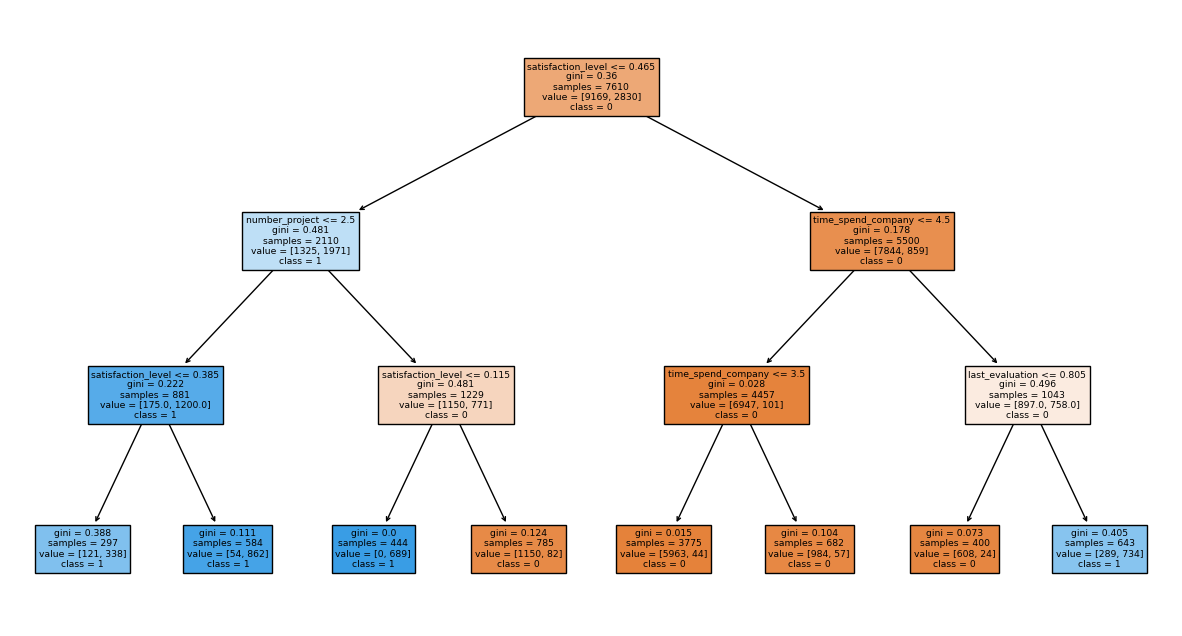

In [554]:
best_rf = RandomForestClassifier(max_depth=3, max_features=None, min_samples_leaf=0.02, min_samples_split=0.05, 
                                 random_state=100).fit(x_train,y_train)

fig, ax = plt.subplots(figsize=(15,8))
tree.plot_tree(best_rf.estimators_[0],
              feature_names=x_train.columns,
              class_names=np.unique(y_train.values).astype(str),
              filled=True)

plt.show()

From this model, we can see that the most important factors were <b>Satisfaction Level</b>, <b>Number of Projects</b>, <b>Time Spent at the Company</b>, and <b>Line Manager Evaluation</b>.  

But how well does this model perform on our test dataset?

<h3>Model Performance on the Test Dataset</h3>

In [573]:
# predict the test data
y_pred = best_rf.predict(x_test)

model_accuracy = metrics.accuracy_score(y_test,y_pred)
model_precision = metrics.precision_score(y_test,y_pred)
model_f1 = metrics.f1_score(y_test,y_pred)
model_recall = metrics.recall_score(y_test,y_pred)

print("Test Data Evaluation: \n" + 
      "Accuracy: " + str(round(model_accuracy,3)) + "\n" +
      "Precision: " + str(round(model_precision,3)) + "\n" +
      "F1 Score: " + str(round(model_f1,3)) + "\n" +
      "Recall: " + str(round(model_recall,3)))

Test Data Evaluation: 
Accuracy: 0.946
Precision: 0.864
F1 Score: 0.891
Recall: 0.919


The most important factor we are interested in is <b>Recall</b>, because we want to catch as many people at risk of resigning as possible.  The score we achieved for recall is approximately ```91.9%```.  However, other metrics were very high including an accuracy of ```94.6%```.  Our precision is a little lower at ```86.4%```, because we have some false positives, but we are less concerned about this.

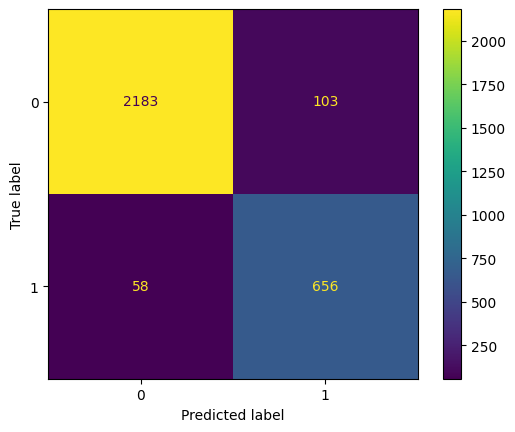

In [580]:
# make a confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)
disp = metrics.ConfusionMatrixDisplay(cm)
disp.plot(); plt.show()

From this Confusion Matrix, we can see that our model is very good at predicting employees who resign.  We do see some false positives as shown by the ```Recall``` metric above, but this is not concerning for us.  In fact only around 5% of non-resigners are incorrectly identified as resigning.

<h2>Takeaways</h2>

<h3>Model Insights</h3>

Our decision tree model shows that the most important predictors for an employee resigning are <b>Satisfaction Level</b>, <b>Number of Projects</b>, <b>Time Spent at the Company</b>, and <b>Line Manager Evaluation</b>.  Some of these are modifiable factors that Salifort Motors can improve to improve employee retention.  These would be worth exploring with the relevant stakeholders further to improve our insights.

<h4>Employee Satisfaction</h4>
Most employees who resign are unsatisfied.  What feedback and monitoring measures does the company have in place to track employee satisfaction?  Could interventions be produced to identify employees with low satisfaction, and intervene?  

Employees with medium satisfaction and a lot of projects are not very likely to leave.  Are these employees content with their workload and this increases satisfaction?  

However, some employees who resign are very satisfied.  Are these employees being lured to other companies by promotions, salary increase, or better extra-work conditions (e.g., benefits, commuting time)?  Is it possible to contact these employees and perform informative interviews to see why they resigned?

<h4>Number of Projects</h4>
Unsatisfied employees with a low number of projects (less than three) are more likely to resign.  Are these employees feeling undervalued?  Do they have a lot of time waiting for feedback without other work to do?  

Satisfied employees however, are not affected by the number of projects they are assigned to.  Is there something additional they are providing thesmelves with, e.g., training and development, that is taking up the remaining time?  Could this be promoted to unsatisfied employees with free time to improve their satisfaction?

<h4>Line Manager Evaluation</h4>
Line manager evaluation has an interaction with satisfaction.  Employees who are satisfied are not more likely to resign if their evaluation is poor. Unsatisfied employees are more likely to have very high or very low evaluations.  This suggests that line manager evaluations are identifying two distinct groups - those likely to leave because they are poor at their job, and those who are likely to leave because they are very good at their job.  However, the evaluation by itself is not sufficient and it must be combined with employee rated satisfaction.

<h4>Time Spent at the Company</h4>
Most employees who resign do so after 3 years of tenure at the company.  However, this is mostly due to departments with high turnover such as Sales and Technical Support.  On an employee level, the likelihood of resigning increases with tenure until 5 years, after which employees are likely to stay for their career duration.  Is it the case that small concerns add up and after five years employee satisfaction reaches a critical level?  Alternatively, is it the case that employees who stay in one place for five years put out sufficient roots that changing job is not worth it?

<h3>Grand Summary</h3>
The most important factor in whether an employee resigns is their level of satisfaction.  To decrease employee loss through resignation, and to decrease costs from hiring and retraining - Salifort Motors should focus on identifying the key sources of employee satisfaction.

An example method of doing this would be using anonymous surveys where employees can leave detailed feedback. Another method would be to have open townhalls with leadership where problems can be raised without going through a lengthy structure.  

Salifort Motors also must be aware that some high-performing satisfied employees are leaving for reasons that are not covered in this dataset.  It would be worth identifying these individuals and gathering information on their reasons for resignation, as this represents the loss of the company's best performers.